In [1]:
import sys
sys.path.append("..")

from fast_scnn_keras import Fast_SCNN
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/quantum/anaconda3/envs/fast_scnn_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/quantum/anaconda3/envs/fast_scnn_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/quantum/anaconda3/envs/fast_scnn_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
INPUT_WIDTH = 256
INPUT_HEIGHT = 256
CHANNELS = 3
model = Fast_SCNN(input_shape=(INPUT_HEIGHT, INPUT_WIDTH, CHANNELS),
                  num_classes=1)\
    .model(show_summary=False, activation='sigmoid')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [53]:
dataset_path = '/home/quantum/Documents/datasets/coco_laptops/images/'

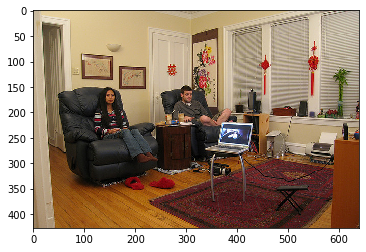

In [66]:
image = cv2.imread(os.path.join(dataset_path, '000000347754.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

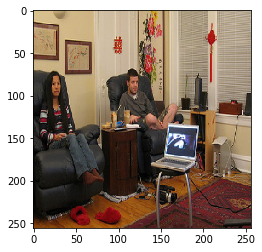

In [67]:
cv2_resized = cv2.resize(image, (384, 384), interpolation = cv2.INTER_LINEAR)
cv2_resized = cv2_resized[64:64+256, 64:64+256]
plt.imshow(cv2_resized)

In [68]:
model.load_weights('/home/quantum/VSProjects/tensorflowjs-real-time-segmentation-style-transfer/fast-scnn/model_upsampling.h5')

In [69]:
result = model.predict(np.expand_dims(cv2_resized, axis=0) / 255)

In [70]:
result.max()

0.98698974

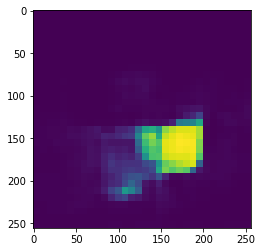

In [71]:
plt.imshow(result.squeeze())

In [74]:
mask = np.load('/home/quantum/Documents/datasets/coco_laptops/masks/000000347754.npy')
resized_mask = cv2.resize(mask, (384, 384), interpolation = cv2.INTER_LINEAR)
resized_mask = resized_mask[64:64+256, 64:64+256]

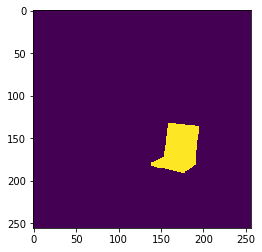

In [75]:
plt.imshow(resized_mask)

In [54]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [28]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [34]:
dice_coef(y_pred=result.squeeze()>0.2, y_true=resized_mask)

0.8457904761904762

In [78]:
from metrics import dice_coef
from losses import cce_dice_loss
from keras.utils import to_categorical
from albumentations import Resize

In [44]:
categorized = to_categorical(mask, num_classes=4)

In [56]:
augm = Resize(256, 256, always_apply=True)

In [57]:
augmented = augm(image=image, mask=mask)

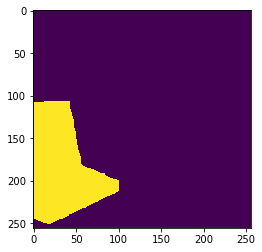

In [58]:
plt.imshow(augmented['mask'])

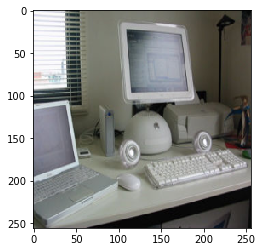

In [59]:
plt.imshow(augmented['image'])

In [60]:
result = fast_scnn.predict(np.expand_dims(augmented['image'], axis=0) / 255)

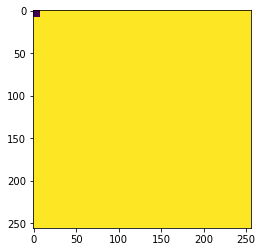

In [64]:
plt.imshow(result.argmax(axis=3).reshape(256,256))

In [87]:
import tensorflow as tf
from keras.losses import categorical_crossentropy


categorized_mask = to_categorical(augmented['mask'], num_classes=4)
converted_mask = tf.convert_to_tensor(categorized_mask, dtype='float32')
zero_result = tf.convert_to_tensor(np.zeros((1, 256, 256, 4)), dtype='float32')
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(cce_dice_loss(converted_mask, converted_mask).eval())

[[2.3841858e-08 2.3841858e-08 2.3841858e-08 ... 2.3841858e-08
  2.3841858e-08 2.3841858e-08]
 [2.3841858e-08 2.3841858e-08 2.3841858e-08 ... 2.3841858e-08
  2.3841858e-08 2.3841858e-08]
 [2.3841858e-08 2.3841858e-08 2.3841858e-08 ... 2.3841858e-08
  2.3841858e-08 2.3841858e-08]
 ...
 [2.3841858e-08 2.3841858e-08 2.3841858e-08 ... 2.3841858e-08
  2.3841858e-08 2.3841858e-08]
 [2.3841858e-08 2.3841858e-08 2.3841858e-08 ... 2.3841858e-08
  2.3841858e-08 2.3841858e-08]
 [2.3841858e-08 2.3841858e-08 2.3841858e-08 ... 2.3841858e-08
  2.3841858e-08 2.3841858e-08]]


In [69]:
augmented['mask'].dtype

dtype('uint8')

In [70]:
result.dtype

dtype('float32')

In [72]:
result.shape

(1, 256, 256, 4)

In [88]:
empty_mask = np.zeros((4, 256, 256))

In [89]:
categorized_empty_mask = to_categorical(empty_mask, num_classes=4)

In [90]:
categorized_empty_mask.shape

(4, 256, 256, 4)

In [91]:
from keras.losses import categorical_crossentropy

In [94]:
categorized_mask1 = to_categorical(np.ones((256, 256)), num_classes=4)

In [95]:
categorized_mask1.shape

(256, 256, 4)

In [96]:
categorized_mask1[:, :, 1].sum()

65536.0